#**Digit Prediction from Recorded Speech Audio**

We are going to use audio files that record different speakers saying numerical digits. This type of NN could be useful for detecting spoken digits in an audio-based customer service setting with a voice-based chatbot. First, we need to download the data.

In [1]:
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset

Cloning into 'free-spoken-digit-dataset'...
remote: Enumerating objects: 4243, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 4243 (delta 16), reused 8 (delta 8), pack-reused 4212
Receiving objects: 100% (4243/4243), 30.38 MiB | 33.02 MiB/s, done.
Resolving deltas: 100% (120/120), done.


Here is what the files look like...

In [2]:
!ls free-spoken-digit-dataset/recordings/

0_george_0.wav	   2_george_0.wav     4_george_0.wav	 6_george_0.wav     8_george_0.wav
0_george_10.wav    2_george_10.wav    4_george_10.wav	 6_george_10.wav    8_george_10.wav
0_george_11.wav    2_george_11.wav    4_george_11.wav	 6_george_11.wav    8_george_11.wav
0_george_12.wav    2_george_12.wav    4_george_12.wav	 6_george_12.wav    8_george_12.wav
0_george_13.wav    2_george_13.wav    4_george_13.wav	 6_george_13.wav    8_george_13.wav
0_george_14.wav    2_george_14.wav    4_george_14.wav	 6_george_14.wav    8_george_14.wav
0_george_15.wav    2_george_15.wav    4_george_15.wav	 6_george_15.wav    8_george_15.wav
0_george_16.wav    2_george_16.wav    4_george_16.wav	 6_george_16.wav    8_george_16.wav
0_george_17.wav    2_george_17.wav    4_george_17.wav	 6_george_17.wav    8_george_17.wav
0_george_18.wav    2_george_18.wav    4_george_18.wav	 6_george_18.wav    8_george_18.wav
0_george_19.wav    2_george_19.wav    4_george_19.wav	 6_george_19.wav    8_george_19.wav
0_george_1.wa

We can play one of these files to hear what it sounds like... this person is saying the digit 'two'.

free-spoken-digit-dataset/recordings/2_theo_32.wav


Total Duration: 0.275 seconds.


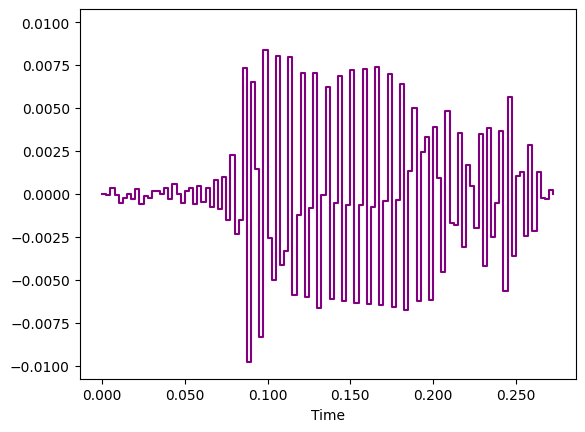

In [11]:
from IPython.display import Audio
from IPython.display import display
import glob
import librosa.display
import librosa

basePath = 'free-spoken-digit-dataset/recordings'

for i,file in enumerate(glob.glob(f"{basePath}/*.wav")):

  if i == 50:
    # What's the name of the file?
    sound_file = f'{file}'
    print(sound_file)

    # Play the audio file.
    wn = Audio(sound_file, autoplay=True) ##
    display(wn)

    # Draw the waveform plot of the audio signal.
    y,sr=librosa.load(sound_file, sr=400) # I am going to be downsampling these files from 8kHz to 400Hz.
    librosa.display.waveshow(y,sr=sr, axis='time', color='purple',offset=0.0)

    # Write out how long the file is in seconds.
    print(f'Total Duration: {librosa.get_duration(y=y,sr=sr)} seconds.')

    break

What does .wav data actually look like?

In [12]:
from scipy.io import wavfile

sampling_rate, data = wavfile.read(sound_file)
print(f'Song is originally sampled at {sampling_rate} times per second.')
print(f'The first file contains a total of {len(data)} samples, thus the song length is {len(data)/sampling_rate} seconds.')
print(f'Here are the first 15 samples of that first recording...{data[:15]}.')

Song is originally sampled at 8000 times per second.
The first file contains a total of 2185 samples, thus the song length is 0.273125 seconds.
Here are the first 15 samples of that first recording...[ -1   0  -2  -3 -15   0 -12   5 -11  10  -6   4  -8  -6  -4].


#*Prepare Our Data*



For each song, let's convert it into numeric sequences, and construct its label from the file name.


In [ ]:
from pathlib import Path
from scipy.signal import decimate

downsample_factor = 8

def processSong(song):

  filename = Path(song).stem
  label = int(filename[0])

  sampling_rate, data = wavfile.read(song)
  return label,sampling_rate,data

labels = []
sample_rates = []
sequences = []

for i,file in enumerate(glob.glob(f"{basePath}/*.wav")):
  label, sample_rate, sequence = processSong(file)
  labels.append(label)
  sample_rates.append(sample_rate/downsample_factor)

  sequence = decimate(sequence,downsample_factor)

  sequences.append(sequence)

sequences[0]

array([   6.88780249,   -3.91973971,    9.21521462,    9.8624649 ,
        -33.06405848,   21.2631964 ,   -7.05283885,   -9.39271183,
         81.06935856,  -41.05655425,  -31.02466429,   24.87100836,
        -12.70824659,  -25.00881027,  -14.07701644,   61.69234272,
        -44.51777382,  -22.11937217,   30.73599723,  -29.00323672,
         20.96786691,  -26.3076219 ,   -9.26005068,  -14.15269502,
         -7.50968122,   62.59326862,   -0.5913265 ,   39.76853867,
        -20.12271568, -151.96264495,   34.83974582,   81.18601199,
         54.23881966,  139.28431963,  -24.77718579, -241.31172529,
       -170.54032359,  234.12304522,  112.12964972,  -12.08697467,
        155.17030267,  -84.20140836, -153.71946792, -273.25634824,
        132.18099384,  250.52369697,  -69.92697063,  178.06462266,
        -28.60110831, -256.56978984, -245.84819726,  213.23986361,
        184.9018101 ,  -86.51246406,  224.41070803,  -25.34691744,
       -293.79834313, -271.67687593,  292.90595427,  156.65106

All songs have been 'downsampled'. We have ragged lists of numeric values that we need to pad.

In [ ]:
for i in range(3):
  print(f'Recording {i} has a sampling rate of {sample_rates[i]}, and it is {len(sequences[i])} elements long.')

Recording 0 has a sampling rate of 1000.0, and it is 226 elements long.
Recording 1 has a sampling rate of 1000.0, and it is 472 elements long.
Recording 2 has a sampling rate of 1000.0, and it is 361 elements long.


Here we will make an array of 0's and fill in our audio sequences from the left. The longest sequence is an outlier, so we will truncate some recordings. We also then shuffle the sequences. Be careful to ensure you do this, because the original files are alphabetical! They are grouped by the name of the speaker.


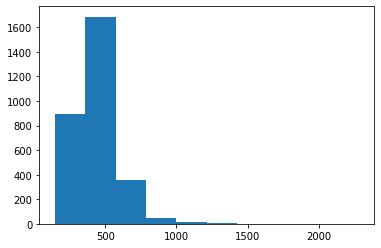

The longest list is 2283 long, but most lists are much shorter.
(3000, 700)


In [ ]:
import tensorflow as tf
import numpy as np
import statistics
import matplotlib.pyplot as plt
from keras.preprocessing import sequence
from sklearn.preprocessing import MinMaxScaler

len_lists = [len(x) for x in sequences]
plt.hist(len_lists)
plt.show()
print(f'The longest list is {max(len_lists)} long, but most lists are much shorter.')

# We can pad the sequences to have a common length (and chop off the end of really long ones)
labels = np.stack(labels)

# Be careful with this pad sequences function! By default it pads at the front...
# If you pad the wrong end and then truncate that can have a huge impact on model accuracy (e.g., 10%)
padded_sequences = sequence.pad_sequences(sequences, maxlen=700,padding="post")

# We might use a min-max scaler here to whiten our data. Note that audio data is already generally centered around 0 though! So, it's not that important.
#scaler = MinMaxScaler(feature_range=(-1, 1))
#scaler = scaler.fit(padded_sequences)
#padded_sequences = scaler.transform(padded_sequences)

# Shuffling observations, because certain voices come earlier in the file system, and others later.
shuffled_indices= np.arange(padded_sequences.shape[0])
np.random.shuffle(shuffled_indices)
padded_sequences = padded_sequences[shuffled_indices,:]
labels = labels[shuffled_indices]

print(padded_sequences.shape)

In [ ]:
padded_sequences[0]

array([-1101,   173,   -97,    97,   -87,   142,  -117,    70,    10,
        -148,   140,   -34,    35,   -47,    67,   -63,   -27,    83,
        -130,   125,    27,  -133,    72,    33,   -65,    39,    -4,
         -57,    70,   -47,    27,    75,  -120,    75,   -19,   -74,
         103,   -73,    24,    71,   -67,   -14,    32,   -26,    -2,
          47,   -55,    23,     1,    -3,    31,   -35,     3,   -12,
          41,   -26,   -10,    49,   -45,    27,   -40,   -14,    46,
         -37,    51,     9,   -68,    45,    20,  -100,   104,    -5,
         -95,   128,   -91,     9,    46,   -27,    29,   -82,    73,
         -53,    34,    49,   -97,    82,   -74,    17,    44,   -28,
          17,   -12,     1,    10,     9,   -74,    77,   -25,   -49,
         105,   -70,    14,    28,   -53,    25,     8,   -27,     5,
          38,   -40,   -12,    69,   -46,   -32,    70,   -24,   -23,
          44,   -40,   -35,    78,   -37,   -29,    72,   -79,    41,
          12,   -42,

#*Temporal (1D) Convolutions*

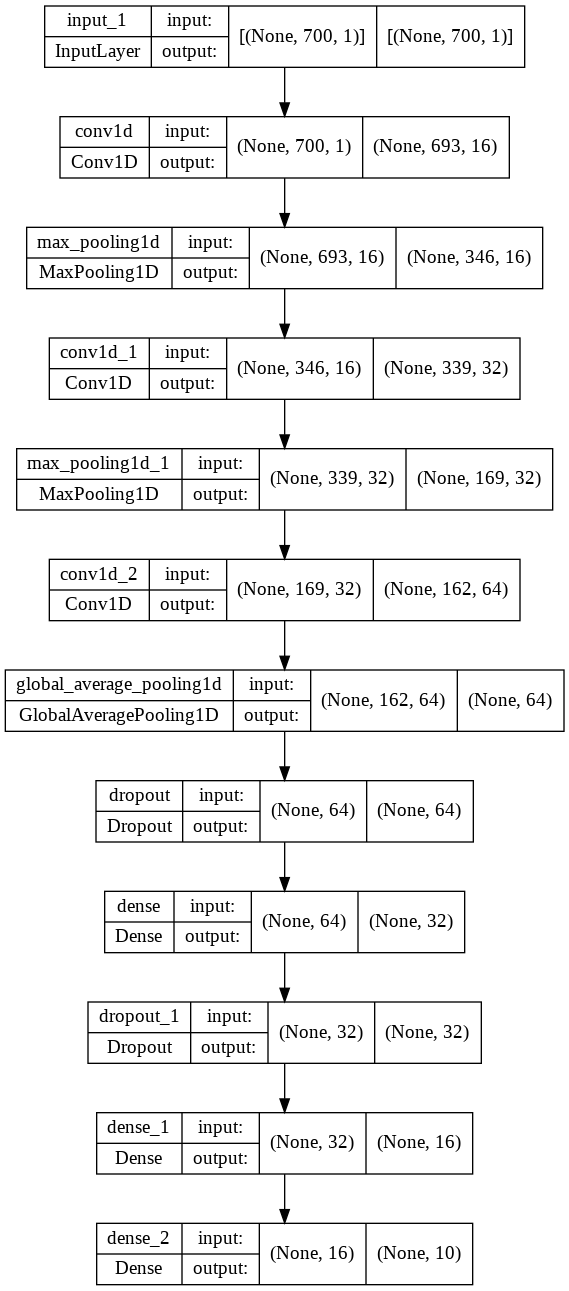

In [ ]:
from tensorflow import keras
from keras import layers

inputs = keras.Input(shape=(padded_sequences.shape[1], 1))
x = layers.Conv1D(16, 8, activation="relu")(inputs) # 1D Convolution with 16 channels / filters, and a window length of 8 (kernel size). Stride here is 1, no padding.
x = layers.MaxPooling1D(2)(x) # Then we apply max pooling, with window of 2 (and stride of 2)
x = layers.Conv1D(32, 8, activation="relu")(x) # Then 32 filters, window of 8.
x = layers.MaxPooling1D(2)(x) # Pool by blocks of two values in each sequence (again, means we attempt to divide sequence length in half)
x = layers.Conv1D(64, 8, activation="relu")(x) # Again 64 filters, with sequence length of 8 this time.
x = layers.GlobalAveragePooling1D()(x) # We apply global average pooling to the resulting 64 feature maps (i.e., what high level patterns were more or less present across the series)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32,activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(16,activation="relu")(x)
outputs = layers.Dense(10,activation="softmax")(x) # Linear activation output.
model = keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
keras.utils.plot_model(model,show_shapes=True)

Let's try fitting this model...

In [ ]:
# We are making a different callback so we don't overwrite our last model (we might want to compare them)
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="audio_conv.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(padded_sequences,labels,validation_split=0.2,batch_size=25,epochs=200,callbacks=callbacks)

Epoch 1/200
96/96 [==============================] - 11s 8ms/step - loss: 8.9866 - sparse_categorical_accuracy: 0.0983 - val_loss: 2.3082 - val_sparse_categorical_accuracy: 0.0917
Epoch 2/200
96/96 [==============================] - 0s 5ms/step - loss: 2.3636 - sparse_categorical_accuracy: 0.0908 - val_loss: 2.2938 - val_sparse_categorical_accuracy: 0.1217
Epoch 3/200
96/96 [==============================] - 0s 5ms/step - loss: 2.3137 - sparse_categorical_accuracy: 0.1167 - val_loss: 2.2869 - val_sparse_categorical_accuracy: 0.1400
Epoch 4/200
96/96 [==============================] - 0s 5ms/step - loss: 2.2984 - sparse_categorical_accuracy: 0.1071 - val_loss: 2.2910 - val_sparse_categorical_accuracy: 0.1400
Epoch 5/200
96/96 [==============================] - 0s 5ms/step - loss: 2.2939 - sparse_categorical_accuracy: 0.1262 - val_loss: 2.2724 - val_sparse_categorical_accuracy: 0.1817
Epoch 6/200
96/96 [==============================] - 0s 5ms/step - loss: 2.2925 - sparse_categorical_acc

If we plot model accuracy over training... we get up to about 70% accuracy in the validation data. Not bad!

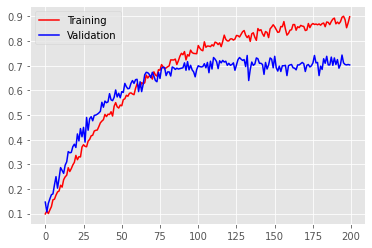

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.plot(history.history['sparse_categorical_accuracy'],c="r")
plt.plot(history.history['val_sparse_categorical_accuracy'],c="b")
plt.legend(['Training','Validation'])
plt.show()